In [5]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_fun.field import D1Field
from user_fun.get_net import ForwardNetwork
from user_fun.ds import get_data_loader

# 保证迭代参数与DEEPXDE一致
batch_size = 16
epoch_size = 16

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_str = "cpu"
device = torch.device(device_str)

field = D1Field([-1,1])
pde_input = field.get_field_rand(epoch_size)
pde_output = np.zeros([epoch_size,1])
pde_loader = get_data_loader([pde_input,pde_output],batch_size = batch_size, \
    device_str = device_str)

bc_input = np.array([[-1],[1]])
bc_input = np.tile(bc_input, (epoch_size//2,1))
bc_output = np.zeros([epoch_size,1])
bc_loader = get_data_loader([bc_input,bc_output],batch_size = batch_size, \
    device_str = device_str)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)
                               
def pinn_loss(x_in, model):
    x_in.requires_grad=True
    
    U = model(x_in)
    u = U[:,[0]]
    # p,u,v shape = (128*1)
    # 计算一阶导
    dudx = grad(u, x_in)[0]
    du2dx2 = grad(dudx, x_in)[0]
    loss = -du2dx2 - (torch.pi ** 2) *torch.sin(torch.pi * x_in)
    return loss

import torch.nn as nn
class ForwardNetwork(nn.Module):
    def __init__(self, net_size_vec=[2,64,64,64,64,3]):
        super(ForwardNetwork, self).__init__()
        sqnet_para_list = []
        # like [2,128,64,32,2], iter end in idx 3(32)
        for i in range(len(net_size_vec)-2):
            sqnet_para_list.append(
                nn.Linear(net_size_vec[i],net_size_vec[i+1]),
            )
            sqnet_para_list.append(nn.Tanh())
        
     #   sqnet_para_list.append(nn.BatchNorm1d(net_size_vec[-2]))
        sqnet_para_list.append(
            nn.Linear(net_size_vec[-2],net_size_vec[-1])
            )
        
        self.linear_relu_stack = nn.Sequential(
            *sqnet_para_list
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

best_loss = np.inf
best_model = -1

# TODO：把这个库封装进类
# TODO: 添加一个logger对象
def custom_train_test_loop(model,loader_list,control_str,loss_fn,optimizer):
    global best_loss
    global best_model 
    pde_loader,bc_loader = loader_list
    if control_str == 'train':
        model.train()
    if control_str == 'test':
        model.eval()
        ave_pde_loss,ave_bc_loss,ave_all_loss  = 0,0,0

    batch_num = 0
    for (x_pde, y_pde),(x_bc, y_bc) in zip(pde_loader, bc_loader):
        batch_num = batch_num + 1

        # 第一种：计算pde损失
        pde_loss_list = pinn_loss(x_pde, model)
        pde_loss_val = loss_fn(pde_loss_list,y_pde)

        # 第二种：计算bc损失
        y_pred_bc = model(x_bc)
        bc_loss_val = loss_fn(y_bc , y_pred_bc)

        # 计算总损失
        loss = pde_loss_val + bc_loss_val

        # 反向传播
        optimizer.zero_grad()

        if control_str == 'train':
            loss.backward()
            optimizer.step()
        if control_str == 'test':
            ave_pde_loss = ave_pde_loss + pde_loss_val
            ave_bc_loss = ave_bc_loss + bc_loss_val
            ave_all_loss = ave_all_loss + loss
            
    if control_str == 'test':
        ave_pde_loss, ave_bc_loss, ave_all_loss = ave_pde_loss/batch_num, \
            ave_bc_loss/batch_num, ave_all_loss/batch_num
        if ave_all_loss < best_loss:
            best_loss = ave_all_loss
            best_model = copy.deepcopy(model)
        return ave_pde_loss, ave_bc_loss, ave_all_loss


pde_loss_list = []
dat_loss_list = []
loss_list = []

for epoch in range(1000):
    custom_train_test_loop(model,[ pde_loader,bc_loader],'train',loss_fn, optimizer)
    if epoch%100 == 0:
        ave_pde_loss, ave_bc_loss, ave_all_loss = \
            custom_train_test_loop(model, [pde_loader,bc_loader],'test',loss_fn, optimizer)
        print(f'epoch{epoch}')
        print(f'loss{ave_all_loss}', f'pde_loss{ave_pde_loss}', f'data_loss{ave_bc_loss}')

        pde_loss_list.append(ave_pde_loss)
        dat_loss_list.append(ave_bc_loss)
        loss_list.append(ave_all_loss)


epoch0
loss53.08545684814453 pde_loss53.064361572265625 data_loss0.02109687775373459
epoch100
loss0.26689615845680237 pde_loss0.1246003657579422 data_loss0.14229579269886017
epoch200
loss0.0003558187745511532 pde_loss0.0003506823268253356 data_loss5.1364581850066315e-06
epoch300
loss0.000260557426372543 pde_loss0.00025964633096009493 data_loss9.111016652241233e-07
epoch400
loss0.0002348420093767345 pde_loss0.0002345833054278046 data_loss2.587007656984497e-07
epoch500
loss0.00021372530318330973 pde_loss0.0002135616960003972 data_loss1.6360027643713693e-07
epoch600
loss0.00019346865883562714 pde_loss0.00019332417286932468 data_loss1.4448882268425223e-07
epoch700
loss0.00017412123270332813 pde_loss0.00017398124327883124 data_loss1.3998719339269883e-07
epoch800
loss0.000155882109538652 pde_loss0.00015574651479255408 data_loss1.3558778277911188e-07
epoch900
loss0.00013883848441764712 pde_loss0.0001387106894981116 data_loss1.2779103997218044e-07


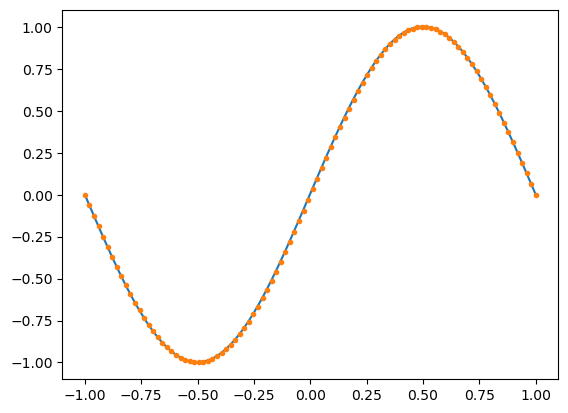

In [6]:

x_cpu = torch.tensor(np.linspace(-1,1,100).reshape(100,1))
x = x_cpu.to(torch.float32).to(device)
best_model.eval()
y = best_model(x)
y_cpu = y.cpu().detach().numpy()
fig,ax = plt.subplots()
ax.plot(x_cpu,y_cpu)
ax.plot(x_cpu,np.sin(np.pi*x_cpu),'.')



